In [57]:
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import gensim, logging
import numpy as np
import random
import tsne

In [12]:
def create_df(name):
    filename = name + '.csv'
    df = pd.read_csv(filename, header=None, delimiter='\t',error_bad_lines=False,dtype=str)
    df.columns=['tweet']
    df.dropna(axis=0,how='any',inplace=True)        
    df.info()
    return df

In [13]:
def replace(s):
    s_lst = s.split(' ')
    for i in range(len(s_lst)):
        if 'http' in s_lst[i] or 'www' in s_lst[i]:
            s_lst[i] = 'HYPERLINK'
        if '@' in s_lst[i]:
            s_lst[i] = 'USER'
    s = ' '.join(s_lst)
    return s

In [14]:
def clean_df(df,name):
    df_iterator = df.iterrows()
    idx = 1
    str_list = []
    lst_list = []
    k = 1000000
    step = 1000000
    for i, row in df_iterator:
        s = row['tweet'].lower()
        if 'http' in s or 'www' in s:
            s = replace(s)
        if '@' in s:
            s = replace(s)
        tokenizer = RegexpTokenizer('\w+')
        lst = tokenizer.tokenize(s)
        if i > k:
            print 'conversion completed up to: ' + str(k) + ' lines'
            k += step
        s = ' '.join(lst)
        if s == '""' or len(s) < 3:
            continue
        # add to a list
        lst_list.append(lst)
        str_list.append(s)
        idx += 1    
    df_str = pd.DataFrame({'tweet': str_list})
    df_str.to_csv(name + '_tweets.txt',header=False,index=False)
    return lst_list

In [20]:
def read_df(df):
    df_iter = df.iterrows()
    str2lst = []
    k = 200000
    step = 200000
    for i, row in df_iter:
        #print row[0]
        s = str(row[0])
        tokenizer = RegexpTokenizer('\w+')        
        lst = tokenizer.tokenize(s)
        for e in lst:
            e.decode(encoding='utf-8', errors='ignore')
        if i > k:
            print("iteration: " + str(k))
            k += step
        str2lst.append(lst)
    return str2lst  

In [41]:
def weighted_choice_sub(weights):
    rnd = random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i

In [42]:
def get_indices(weights, X, N):
    indices = []
    size = 0
    while size != N:
        idx = weighted_choice_sub(weights)
        #print idx
        if idx not in indices:
            too_small = False
            for x in X[idx]: 
                if abs(x) < 0.0001: 
                    too_small = True
                    break
            if too_small: continue
            indices.append(idx)
            size += 1
    return indices

In [43]:
def normalize(X):
    X_norm = []
    for i, x in enumerate(X):
        total = sum(x)
        v = [x_i / float(total) for x_i in x]
        if i % 250000 == 0: 
            print(x)
            print("/-----/")
            print(v)
        X_norm.append(v)
    return np.array(X_norm)

In [44]:
def make_score_files(model, filelabel):
    with open(filelabel + '_scores.csv', 'w') as scorefile:
        with open(filelabel + '_words.csv', 'w') as wordfile:
            count_scores = 0
            count_words = 0
            for i in range(len(model.index2word)):
                word = model.index2word[i]
                if i == 80:
                    continue
                try:
                    wordfile.write(word + '\n')
                    score = model[word]
                    scores = [str(x) for x in score]
                    scorefile.write('\t'.join(scores) + '\n')
                    #print("word: " + word)
                    count_scores += 1
                    count_words += 1
                except:
                    print "Not found: " + str(i) + ": " + word
                    continue
            print("counts: scores = " + str(count_scores) + "; words = " + str(count_words))     
            #scorefile.write('\n')
            #wordfile.write('\n')    

In [15]:
#######################
## generate data set ##
#######################
disney_df_1 = create_df('disney_tweets_1')
disney_df_2 = create_df('disney_tweets_2')
disney_df_3 = create_df('disney_tweets_3')
disney_df_4 = create_df('disney_tweets_4')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
tweet    1000000 non-null object
dtypes: object(1)
memory usage: 15.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
tweet    1000000 non-null object
dtypes: object(1)
memory usage: 15.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
tweet    1000000 non-null object
dtypes: object(1)
memory usage: 15.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
tweet    1000000 non-null object
dtypes: object(1)
memory usage: 15.3+ MB


In [16]:
disney = [disney_df_1, disney_df_2, disney_df_3, disney_df_4]
df = pd.concat(disney, axis=0)

In [18]:
disney_clean = clean_df(df, 'disney_4Mil')

In [24]:
len(disney_clean)

4000000

In [21]:
#######################
## read the data set ##
#######################
SW_df = pd.read_csv('disney_4Mil_tweets.txt',header=None)
SW_tweets = read_df(SW_df)

iteration: 200000
iteration: 400000
iteration: 600000
iteration: 800000
iteration: 1000000
iteration: 1200000
iteration: 1400000
iteration: 1600000
iteration: 1800000
iteration: 2000000
iteration: 2200000
iteration: 2400000
iteration: 2600000
iteration: 2800000
iteration: 3000000
iteration: 3200000
iteration: 3400000
iteration: 3600000
iteration: 3800000


In [25]:
SW_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000000 entries, 0 to 3999999
Data columns (total 1 columns):
0    object
dtypes: object(1)
memory usage: 61.0+ MB


In [22]:
k = 1000000
step = 1000000
i = 0
l = []
for lst in SW_tweets:
    i += 1
    #print lst
    if i > k:
        print("iteration: " + str(k))
        k += step
    lst_u = [s.decode('utf-8','ignore') for s in lst]
    l.append(lst_u)

iteration: 1000000
iteration: 2000000
iteration: 3000000


In [26]:
bigram = gensim.models.phrases.Phrases(l)

In [27]:
trigram = gensim.models.phrases.Phrases(bigram[l])

In [28]:
bigram.save('disney_bigrams.txt')
trigram.save('disney_trigrams.txt')

In [29]:
import random
import time
freq = 10
size_NN = 280
nbr_threads = 5
model = gensim.models.Word2Vec(min_count=freq,size=size_NN, workers=nbr_threads, alpha=0.025, min_alpha=0.025)  # use fixed learning rate
start = time.time()
model.build_vocab(trigram[bigram[l]])
end = time.time()
print("building vocabulary completed in: " + str(end - start))
for epoch in range(10):
    print('starting epoch: ' + str(epoch))
    start = time.time()
    random.shuffle(l)
    end = time.time()
    print("shuffling completed in: " + str(end - start))
    start = time.time()
    model.train(trigram[bigram[l]])
    #model.save('disney_' + str(epoch) + '.txt')
    end = time.time()
    print("training completed in: " + str(end - start))
    #model.alpha -= 0.002  # decrease the learning rate
    #model.min_alpha = model.alpha  # fix the learning rate, no decay

building vocabulary completed in: 744.765414
starting epoch: 0
shuffling completed in: 3.0195069313
training completed in: 4540.81570005
starting epoch: 1
shuffling completed in: 3.27707886696
training completed in: 4467.06786799
starting epoch: 2
shuffling completed in: 3.39003610611
training completed in: 4547.87283492
starting epoch: 3
shuffling completed in: 3.11320304871
training completed in: 4457.00728393
starting epoch: 4
shuffling completed in: 3.22964715958
training completed in: 4425.73590183
starting epoch: 5
shuffling completed in: 3.11527490616
training completed in: 4438.50793099
starting epoch: 6
shuffling completed in: 3.09811401367
training completed in: 4425.73457503
starting epoch: 7
shuffling completed in: 3.11548018456
training completed in: 4431.52172279
starting epoch: 8
shuffling completed in: 3.04606604576
training completed in: 4444.63430285
starting epoch: 9
shuffling completed in: 3.19593501091
training completed in: 4424.53360605


In [32]:
model.init_sims(replace=True)
model.save('disney_w2v.txt')

In [45]:
make_score_files(model, 'disney_')

counts: scores = 83686; words = 83686


In [48]:
# visualization
X = np.loadtxt("disney__scores.csv")

In [49]:
labels = np.genfromtxt("disney__words.csv", dtype=str)

In [50]:
weighted_idx = [ model.vocab[l].count for l in labels ]

In [52]:
random.seed(587458)
indices = get_indices(weighted_idx, X, 3000)

In [1]:
## check for doubles
count = {}
for i in indices:
    if i not in count.keys():
        count[i] = 1
    else:
        count[i] +=1
        if count[i] > 1:
            print(str(i) + " is duplicated!!")

NameError: name 'indices' is not defined

In [4]:
A = 1000 .* [1,2,3]
A

SyntaxError: invalid syntax (<ipython-input-4-578ae371c900>, line 1)

In [54]:
X_sub = X[indices]

In [55]:
for i, x in enumerate(X_sub):
    for xi in x: 
        if abs(xi) <= 0.0001: 
            if i in indices:
                print(str(i) + " is in indices")

In [56]:
labels_sub = labels[indices]

In [58]:
Y = tsne.tsne(X_sub, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  3000 ...
Computing P-values for point  500  of  3000 ...
Computing P-values for point  1000  of  3000 ...
Computing P-values for point  1500  of  3000 ...
Computing P-values for point  2000  of  3000 ...
Computing P-values for point  2500  of  3000 ...
Mean value of sigma:  0.1553337586
Iteration  10 : error is  28.313903362
Iteration  20 : error is  27.4608593017
Iteration  30 : error is  25.3179601263
Iteration  40 : error is  24.4308048722
Iteration  50 : error is  24.1776440777
Iteration  60 : error is  24.0903698667
Iteration  70 : error is  24.038412938
Iteration  80 : error is  23.9962419654
Iteration  90 : error is  23.9509427435
Iteration  100 : error is  23.9298569011
Iteration  110 : error is  4.22097622202
Iteration  120 : error is  3.74052187758
Iteration  130 : error is  3.40982598932
Iteration  140 : error is  3.17018723136
Iteration  150 : error is  2.98638023272
Ite

In [98]:
# clustering
from sklearn.cluster import AffinityPropagation,KMeans,MiniBatchKMeans
from sklearn.mixture import GMM, DPGMM
#y_sub = AffinityPropagation(damping=0.6).fit_predict(X_sub)
#y_sub = KMeans(n_clusters=100).fit_predict(X_sub)
#y_sub = MiniBatchKMeans(n_clusters=30, batch_size=500).fit_predict(X_sn)
#y_sub = DPGMM(n_components=60,covariance_type='diag',alpha=25.0,n_iter=100).fit_predict(X_sub)
y_sub = GMM(n_components=28,covariance_type='diag',n_iter=100).fit_predict(X_sub)

In [99]:
clusters = {}
for i, v in enumerate(y_sub):
    if v in clusters:
        clusters[v].append(i)
    else:
        l = []
        l.append(i)
        clusters[v] = l

In [100]:
#plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
cmin = min(y_sub)
cmax = max(y_sub)
cnorm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

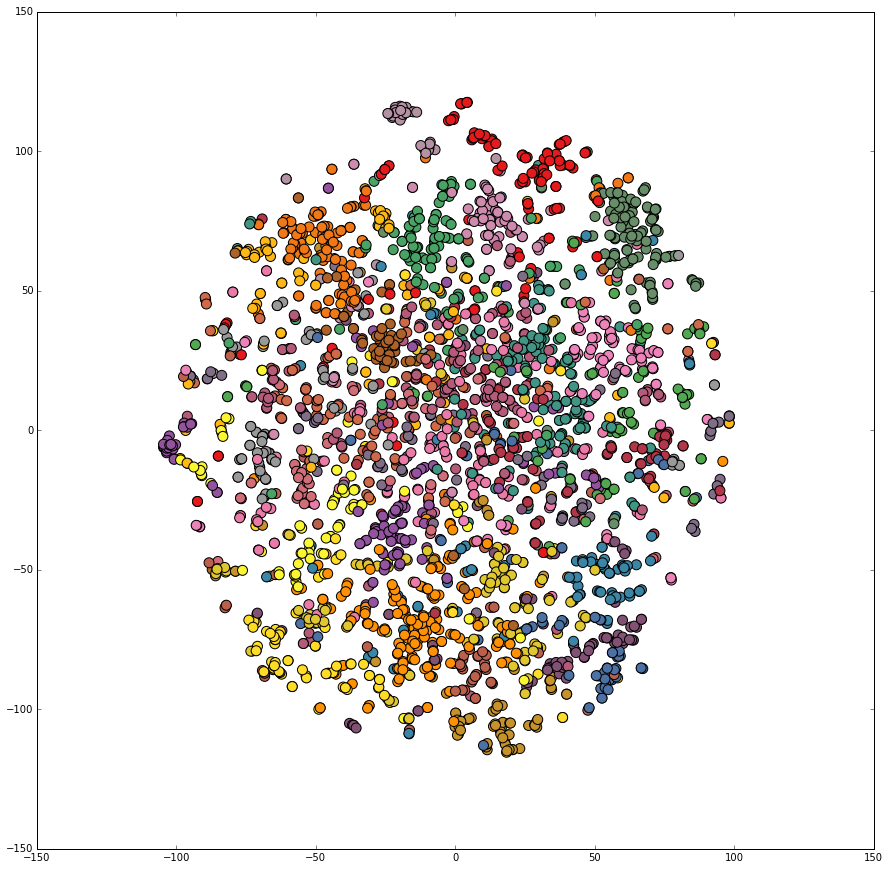

In [102]:
plt.figure(figsize=(15, 15))
# only turn off after checking the axis min/max
#plt.axis('off')
plt.scatter(Y[:,0], Y[:,1], s=100, c=y_sub, cmap=plt.cm.get_cmap('Set1'), norm=cnorm, alpha=1.0)

#for i in range(len(Y[:,0])):
#    plt.annotate(labels_sub[i], (Y[i,0], Y[i,1]))

#plt.savefig('tsne_annotated.png',bbox_inches='tight')
plt.savefig('tsne_disney_GMMs.png',bbox_inches='tight')

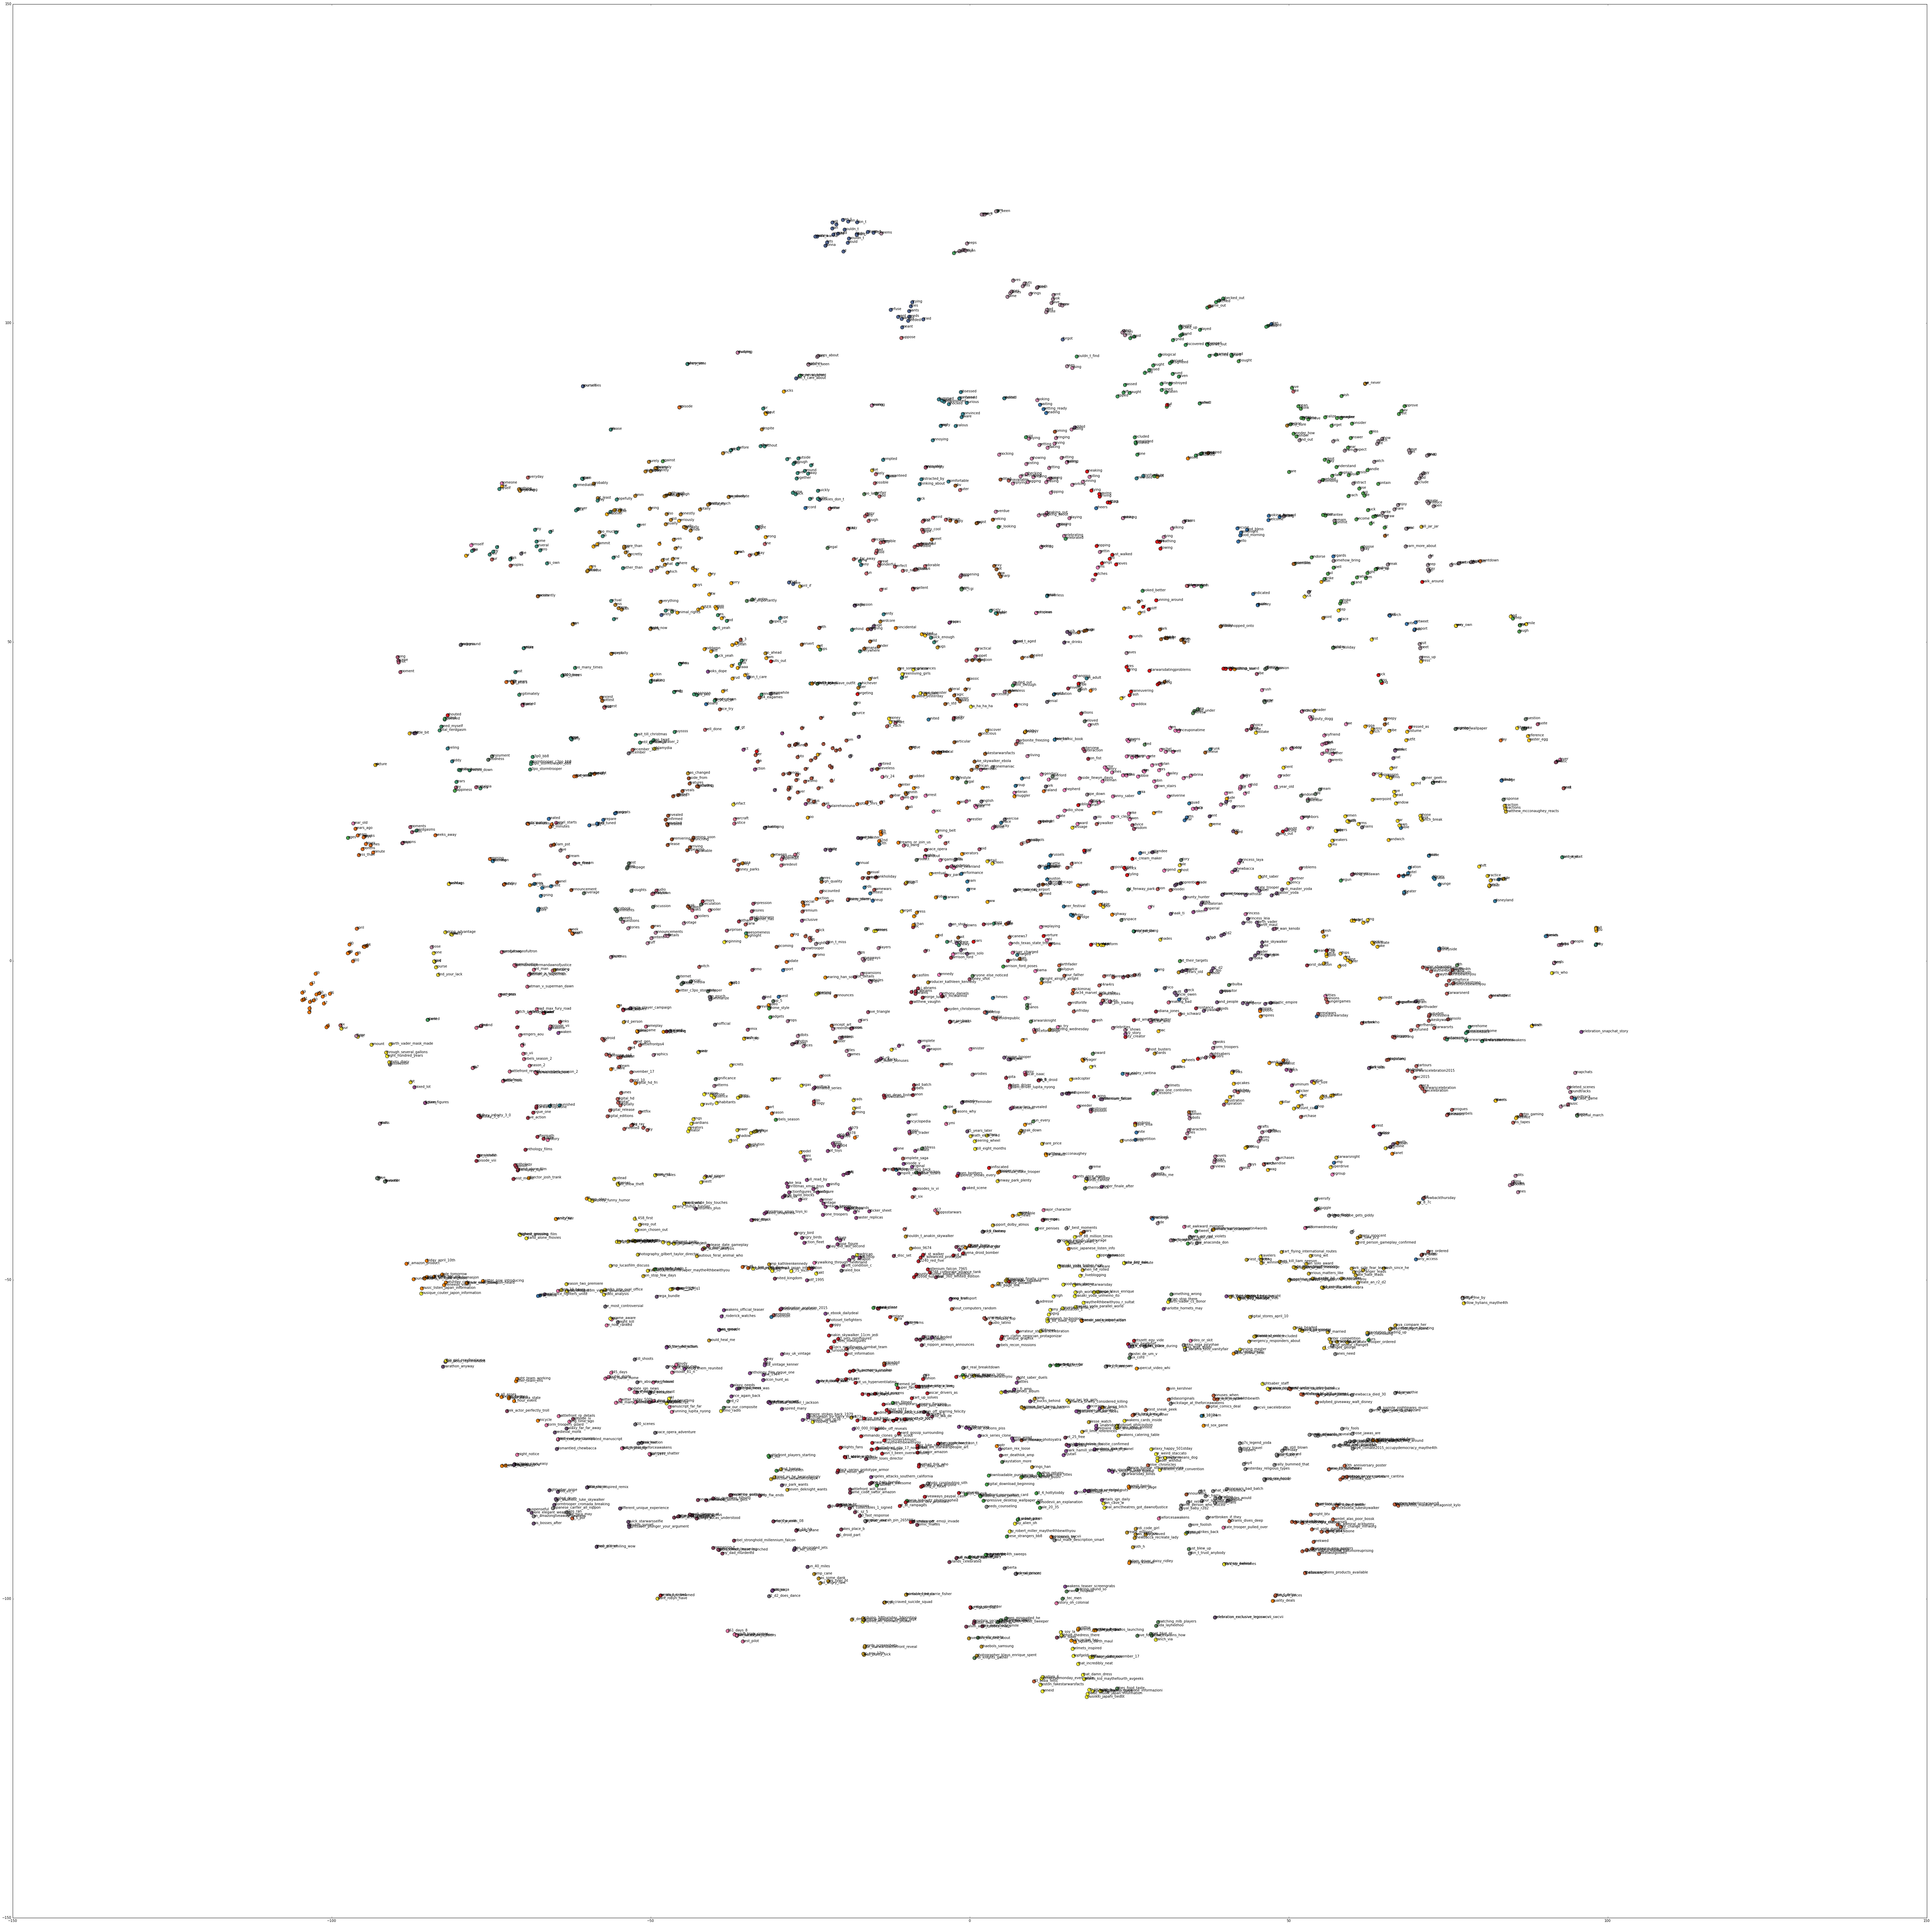

In [68]:
plt.figure(figsize=(100, 100))
# only turn off after checking the axis min/max
#plt.axis('off')
plt.scatter(Y[:,0], Y[:,1], s=100, c=y_sub, cmap=plt.cm.get_cmap('Set1'), norm=cnorm, alpha=1.0)

for i in range(len(Y[:,0])):
    plt.annotate(labels_sub[i], (Y[i,0], Y[i,1]))

plt.savefig('disney_tsne_annotated.png',bbox_inches='tight')
#plt.savefig('disney_tsne_clusters.png',bbox_inches='tight')